<a href="https://colab.research.google.com/github/marcusaxelsson1/Advanced_NN/blob/main/HWD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reservoir Computing Assignment

This assignment involves predicting time series data using the Lorenz system and reservoir computing, a type of recurrent neural network. Follow the steps outlined below to complete your tasks.

## Task 1: Generate Training Set

1. **Generate a training set of time series `x2(t)` by numerically solving Equation (4), with parameters:**
   - $ \sigma = 10 $
   - $ r = 28 $
   - $ b = \frac{8}{3} $

Reference for the task: Exercise 3.2 in *Nonlinear Time Series Analysis* by Kantz and Schreiber.

## Task 2: Setup and Train Reservoir

2. **Set up a reservoir as described in Equation (1) and train the output weights to minimize the energy function when predicting the Lorenz system.**

$$
r_i(t+1) = g\left( \sum_{j=1} w_{ij} r_j(t) + \sum_{k=1}^{N} w_{ik}^{(in)} x_k(t) \right)
$$

$$
O_i(t+1) = \sum_{j=1}^{M} w_{ij}^{(out)} r_j(t+1)
$$


## Task 3: Train and Evaluate Two Reservoirs

3. **Train two reservoirs:**
   - One on the entire Lorenz system. $\sigma$
   - One on a single variable of the Lorenz system, say `x2`. For the single variable reservoir, only predict that variable.

   **Evaluate their prediction performance over a range of different values for the maximal singular value of the reservoir weight matrix `W`. Determine the upper and lower bounds of singular values that allow the reservoir to predict the time series in both cases.**

   **Discuss:**
   - The bounds observed.
   - Differences between the two cases.
   - Why these differences might appear.

   **Hint:** Plot the prediction performance versus the maximal singular value using a log-scale for the x-axis.

## Task 4: Evaluate Prediction Performance

4. **Evaluate how well the reservoir computer predicts the time series `x2(t)` and compare with standard methods.**
   - Determine the maximal Lyapunov exponent $ \lambda_1 $ by numerical simulation of Eq. (4) of the Lorenz system.
   - Check for how many Lyapunov times the time-series prediction works.
   - Plot the prediction error as a function of $ t\lambda_1 $.


In [2]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from numpy import tanh, random
from numpy.linalg import eigvals

In [ ]:
# Lorenz system
def lorenz_system(t, y, sigma=10, rho=28, beta=8/3):
    x1, x2, x3 = y
    return [-sigma * (x1 - x2), x1 * (rho - x3) - x2, x1 * x2 - beta * x3]

# Initial conditions and time span
y0 = [1.0, 1.0, 1.0]
t_span = [0, 200]
t_eval = np.linspace(t_span[0], t_span[1], 10000)

# Solving the system
sol = solve_ivp(lorenz_system, t_span, y0, t_eval=t_eval)
x2 = sol.y[1]



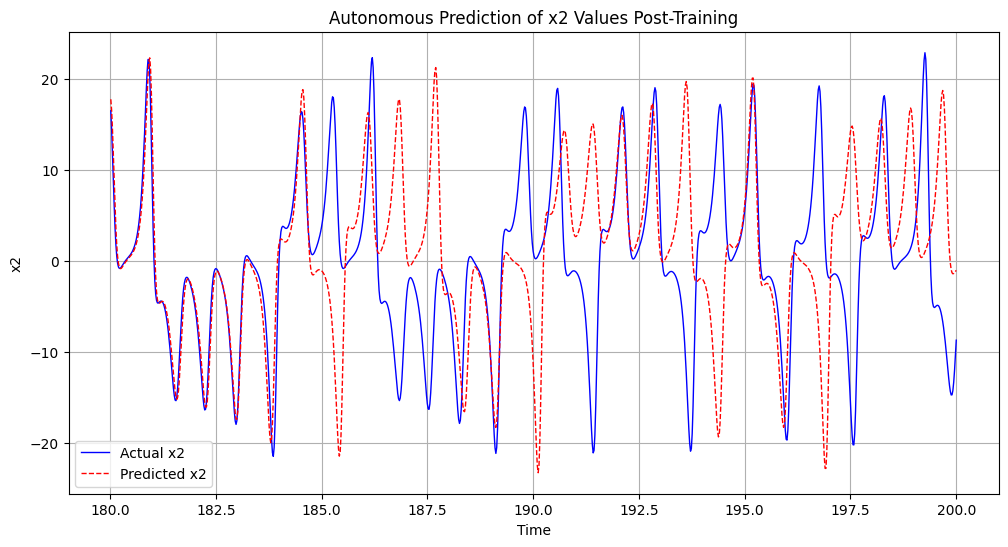

In [ ]:
# Define training and prediction intervals
train_size = int(len(x2) * 0.9)
test_size = len(x2) - train_size  # Remaining for testing

# Parameters for the reservoir
num_neurons = 500
input_scaling = 0.1
reservoir_scaling = 0.95

# Initialize weights
input_weights = random.randn(num_neurons, 1) * input_scaling
reservoir_weights = random.randn(num_neurons, num_neurons)
reservoir_weights *= reservoir_scaling / max(abs(np.linalg.eigvals(reservoir_weights)))

# Reservoir state initialization
reservoir_states = np.zeros((num_neurons, len(x2)))

# Train the reservoir on the training data
for t in range(1, train_size):
    input_term = np.dot(input_weights, x2[t-1]).flatten()
    reservoir_term = np.dot(reservoir_weights, reservoir_states[:, t-1])
    reservoir_states[:, t] = tanh(reservoir_term + input_term)

# Fit the output weights using ridge regression
output_weights = Ridge(alpha=1e-5).fit(reservoir_states[:, :train_size].T, x2[:train_size]).coef_

# Predict using trained weights
predicted = np.zeros(test_size)
reservoir_states_test = reservoir_states[:, train_size-1]  # Initial state for prediction

# The initial predicted value should ideally come from the model based on the last training state
predicted[0] = np.dot(output_weights, reservoir_states_test)

for i in range(1, test_size):
    input_term = np.dot(input_weights, predicted[i-1]).flatten()  # use last predicted value
    reservoir_term = np.dot(reservoir_weights, reservoir_states_test)
    reservoir_states_test = tanh(reservoir_term + input_term)
    predicted[i] = np.dot(output_weights, reservoir_states_test)

# Plot results with corrected predictions
plt.figure(figsize=(12, 6))
plt.plot(t_eval[train_size:train_size + test_size], x2[train_size:train_size + test_size], label='Actual x2', color='blue', linewidth=1)
plt.plot(t_eval[train_size:train_size + test_size], predicted, label='Predicted x2', color='red', linestyle='--', linewidth=1)
plt.title('Autonomous Prediction of x2 Values Post-Training')
plt.xlabel('Time')
plt.ylabel('x2')
plt.legend()
plt.grid(True)
plt.show()


# NEW TRY WITH THE BASE CODE FROM THE LABS

In [49]:
def lorenz_step(t, x, y, z, dt, sigma, rho, beta):
    """Calculate the next step in the Lorenz system."""
    dx = sigma * (y - x) * dt
    dy = (x * (rho - z) - y) * dt
    dz = (x * y - beta * z) * dt

    return t + dt, x + dx, y + dy, z + dz

def lorenz(t0, x0, y0, z0, dt, sigma, rho, beta, iter_num):
    """Calculate the evolution of the Lorenz system."""
    t = np.zeros(iter_num + 1)
    x = np.zeros(iter_num + 1)
    y = np.zeros(iter_num + 1)
    z = np.zeros(iter_num + 1)

    t[0], x[0], y[0], z[0] = t0, x0, y0, z0
    for i in range(iter_num):
        t[i + 1], x[i + 1], y[i + 1], z[i + 1] = (
            lorenz_step(t[i], x[i], y[i], z[i], dt, sigma, rho, beta)
        )

    return t, x, y, z

t, x1, x2, x3 = lorenz(t0=0, x0=1, y0=1, z0=1, dt=0.01,
                    sigma=10, rho=28, beta=8 / 3, iter_num=5_000)

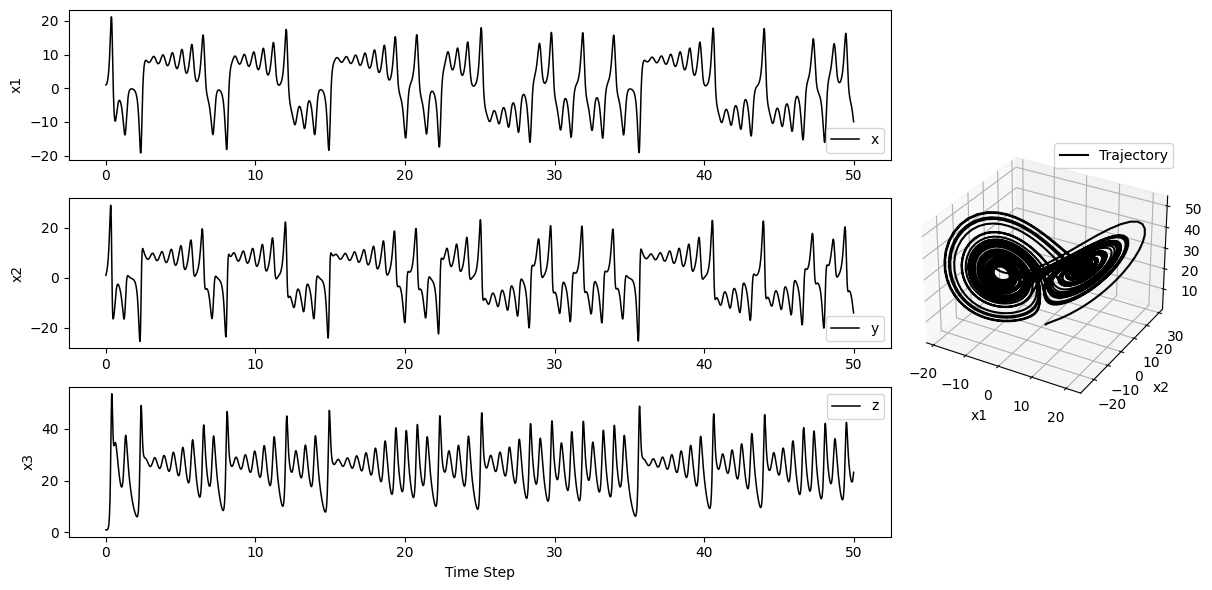

In [50]:

def plotLorenz(t, x1, x2, x3):
  # Create a GridSpec to allocate space for the subplots
  fig = plt.figure(figsize=(12, 6))
  gs = fig.add_gridspec(3, 2, width_ratios=[3, 1])

  # Create the first three subplots
  ax0 = fig.add_subplot(gs[0, 0])
  ax0.plot(t, x1, label="x", color="k", lw=1.1)
  ax0.set_ylabel("x1")
  ax0.legend()

  ax1 = fig.add_subplot(gs[1, 0])
  ax1.plot(t, x2, label="y", color="k", lw=1.1)
  ax1.set_ylabel("x2")
  ax1.legend()

  ax2 = fig.add_subplot(gs[2, 0])
  ax2.plot(t, x3, label="z", color="k", lw=1.1)
  ax2.set_ylabel("x3")
  ax2.legend()
  ax2.set_xlabel("Time Step")

  # Create the 3D subplot
  ax3 = fig.add_subplot(gs[:, 1], projection='3d')
  ax3.plot(x1, x2, x3, label="Trajectory", color="k")
  ax3.set_xlabel("x1")
  ax3.set_ylabel("x2")
  ax3.set_zlabel("x3")
  ax3.legend()

  # Adjust layout
  fig.tight_layout()
  plt.show()

plotLorenz(t,x1,x2,x3)

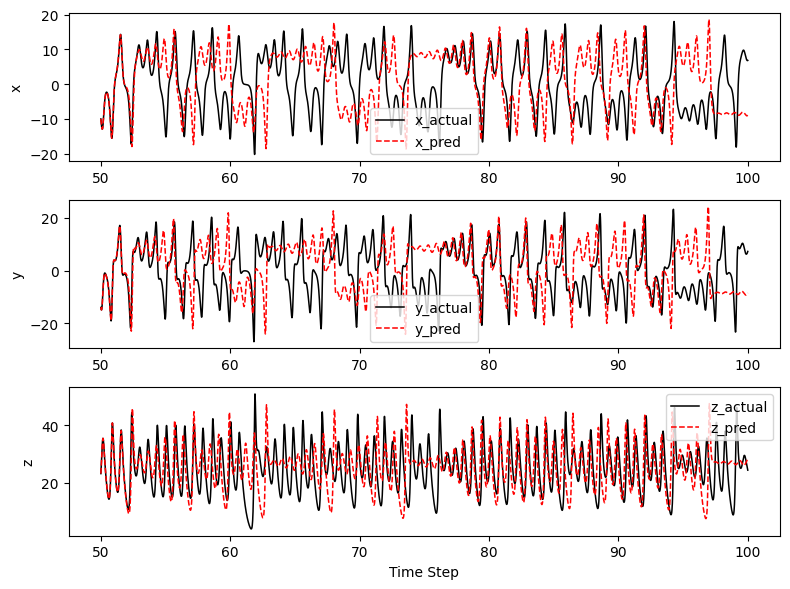

In [51]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Constants
dim_system = 3
dim_reservoir = 300
edge_probability = 0.1
scaling_factor = 1.1
regularization_factor = 0.0001
split_ratio = 0.50
iter_num = 10_000

def initialize_weights(dim_reservoir, dim_system, edge_probability):
    """Initialize input weights."""
    return 2 * edge_probability * (np.random.rand(dim_reservoir, dim_system) - 0.5)

def generate_reservoir(dim_reservoir, edge_probability, scaling_factor):
    """Generate the reservoir adjacency matrix."""
    graph = nx.gnp_random_graph(dim_reservoir, edge_probability)
    graph = nx.to_numpy_array(graph)
    A = 2 * (np.random.rand(dim_reservoir, dim_reservoir) - 0.5) * graph
    eigenvalues, _ = np.linalg.eig(A)
    A = A / np.absolute(np.amax(eigenvalues)) * scaling_factor
    return A

def sigmoid(x):
    """Compute the sigmoid function."""
    return np.where(x >= 0, 1 / (1 + np.exp(-x)), np.exp(x) / (1 + np.exp(x)))

def train_reservoir(A, W_in, xyz_train):
    """Train the reservoir on the training data."""
    dim_reservoir = A.shape[0]
    reservoir_state = np.zeros(dim_reservoir)
    R = np.zeros((dim_reservoir, xyz_train.shape[0]))

    for i in range(xyz_train.shape[0]):
        R[:, i] = reservoir_state
        reservoir_state = sigmoid(np.dot(A, reservoir_state) + np.dot(W_in, xyz_train[i]))

    Rt = np.transpose(R)
    inverse_part = np.linalg.inv(np.dot(R, Rt) + regularization_factor * np.identity(R.shape[0]))
    W_out = np.dot(np.dot(xyz_train.T, Rt), inverse_part)
    return W_out, reservoir_state

def predict_reservoir(A, W_in, W_out, reservoir_state, steps):
    """Make predictions using the trained reservoir."""
    dim_system = W_out.shape[0]
    xyz_pred = np.zeros((steps, dim_system))

    for i in range(steps):
        xyz_pred[i] = np.dot(W_out, reservoir_state)
        reservoir_state = sigmoid(np.dot(A, reservoir_state) + np.dot(W_in, xyz_pred[i]))

    return xyz_pred

def plot_results(t_val, x_val, y_val, z_val, x_pred, y_pred, z_pred):
    """Plot the validation results and predictions."""
    fig, axs = plt.subplots(3, 1, figsize=(8, 6))

    axs[0].plot(t_val, x_val, label="x_actual", color="k", lw=1.1)
    axs[0].plot(t_val, x_pred, label="x_pred", color="r", lw=1.1, linestyle='dashed')
    axs[0].set_ylabel("x")
    axs[0].legend()

    axs[1].plot(t_val, y_val, label="y_actual", color="k", lw=1.1)
    axs[1].plot(t_val, y_pred, label="y_pred", color="r", lw=1.1, linestyle='dashed')
    axs[1].set_ylabel("y")
    axs[1].legend()

    axs[2].plot(t_val, z_val, label="z_actual", color="k", lw=1.1)
    axs[2].plot(t_val, z_pred, label="z_pred", color="r", lw=1.1, linestyle='dashed')
    axs[2].set_ylabel("z")
    axs[2].legend()
    axs[2].set_xlabel("Time Step")

    fig.tight_layout()
    plt.show()

# Main execution

# Step 1: Initialize weights
W_in = initialize_weights(dim_reservoir, dim_system, edge_probability)

# Step 2: Generate reservoir
A = generate_reservoir(dim_reservoir, edge_probability, scaling_factor)

# Step 3: Generate Lorenz system data
t, x, y, z = lorenz(t0=0, x0=1, y0=1, z0=1, dt=0.01, sigma=10, rho=28, beta=8 / 3, iter_num=iter_num)
xyz = list(zip(x, y, z))

# Step 4: Split data into training and validation sets
split_idx = int(iter_num * split_ratio)
t_train, xyz_train = t[:split_idx], np.array(xyz[:split_idx])
t_val, xyz_val = t[split_idx:], np.array(xyz[split_idx:])

# Step 5: Train the reservoir
W_out, reservoir_state = train_reservoir(A, W_in, xyz_train)

# Step 6: Make predictions
xyz_pred = predict_reservoir(A, W_in, W_out, reservoir_state, len(xyz_val))

# Step 7: Extract validation and prediction data for plotting
x_val, y_val, z_val = xyz_val[:, 0], xyz_val[:, 1], xyz_val[:, 2]
x_pred, y_pred, z_pred = xyz_pred[:, 0], xyz_pred[:, 1], xyz_pred[:, 2]

# Step 8: Plot the results
plot_results(t_val, x_val, y_val, z_val, x_pred, y_pred, z_pred)


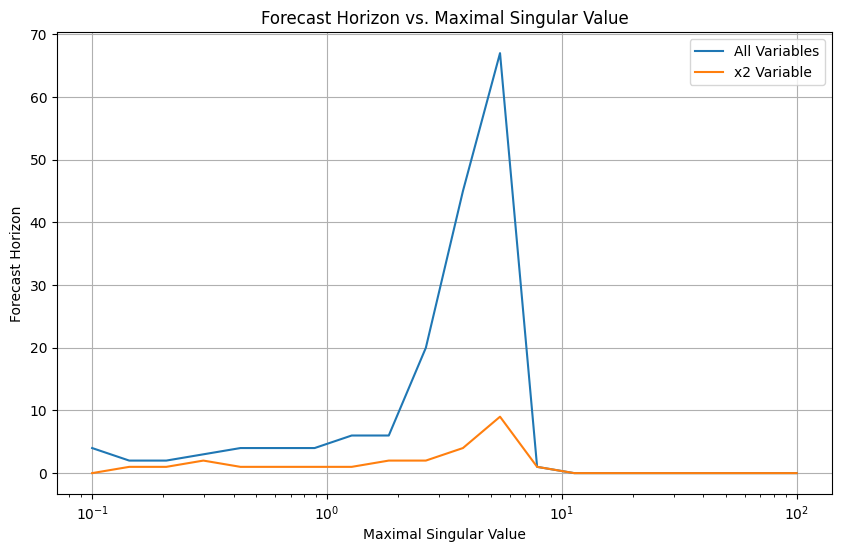

In [61]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Constants
dim_system = 3
dim_reservoir = 500
edge_probability = 0.1
regularization_factor = 0.0001
split_ratio = 0.50
iter_num = 10_000
error_threshold = 0.0001  # Example threshold for forecast horizon

def initialize_weights(dim_reservoir, dim_system, edge_probability):
    """Initialize input weights."""
    return 2 * edge_probability * (np.random.rand(dim_reservoir, dim_system) - 0.5)

def generate_reservoir(dim_reservoir, edge_probability, scaling_factor):
    """Generate the reservoir adjacency matrix."""
    graph = nx.gnp_random_graph(dim_reservoir, edge_probability)
    graph = nx.to_numpy_array(graph)
    A = 2 * (np.random.rand(dim_reservoir, dim_reservoir) - 0.5) * graph
    eigenvalues, _ = np.linalg.eig(A)
    A = A / np.absolute(np.amax(eigenvalues)) * scaling_factor
    return A

def sigmoid(x):
    """Compute the sigmoid function."""
    return np.where(x >= 0, 1 / (1 + np.exp(-x)), np.exp(x) / (1 + np.exp(x)))

def train_reservoir(A, W_in, train_data):
    """Train the reservoir on the training data."""
    dim_reservoir = A.shape[0]
    reservoir_state = np.zeros(dim_reservoir)
    R = np.zeros((dim_reservoir, train_data.shape[0]))

    for i in range(train_data.shape[0]):
        R[:, i] = reservoir_state
        reservoir_state = sigmoid(np.dot(A, reservoir_state) + np.dot(W_in, train_data[i]))

    Rt = np.transpose(R)
    inverse_part = np.linalg.inv(np.dot(R, Rt) + regularization_factor * np.identity(R.shape[0]))
    W_out = np.dot(np.dot(train_data.T, Rt), inverse_part)
    return W_out, reservoir_state

def predict_reservoir_forecast_horizon(A, W_in, W_out, reservoir_state, val_data, error_threshold, dim_system):
    """Predict using the trained reservoir and calculate the forecast horizon."""
    steps = val_data.shape[0]
    pred = np.zeros((steps, dim_system))

    for i in range(steps):
        pred[i] = np.dot(W_out, reservoir_state)
        reservoir_state = sigmoid(np.dot(A, reservoir_state) + np.dot(W_in, pred[i]))

        # Calculate the mean squared error at this step
        mse = np.mean((val_data[i] - pred[i]) ** 2)
        if mse > error_threshold:
            return i  # Return the forecast horizon

    return steps  # If error threshold is not exceeded, return the total number of steps

def evaluate_singular_values_forecast_horizon(singular_values, dim_reservoir, edge_probability, train_data, val_data, error_threshold, single_var=False):
    horizons = []
    for scaling_factor in singular_values:
        # Generate reservoir
        A = generate_reservoir(dim_reservoir, edge_probability, scaling_factor)
        W_in = initialize_weights(dim_reservoir, 1 if single_var else dim_system, edge_probability)

        # Train reservoir
        W_out, reservoir_state = train_reservoir(A, W_in, train_data)

        # Predict using reservoir and calculate forecast horizon
        forecast_horizon = predict_reservoir_forecast_horizon(A, W_in, W_out, reservoir_state, val_data, error_threshold, 1 if single_var else dim_system)
        horizons.append(forecast_horizon)

    return horizons

# Main execution
t, x, y, z = lorenz(t0=0, x0=1, y0=1, z0=1, dt=0.01, sigma=10, rho=28, beta=8 / 3, iter_num=iter_num)
xyz = np.array(list(zip(x, y, z)))
x2 = y

split_idx = int(iter_num * split_ratio)
t_train, xyz_train = t[:split_idx], xyz[:split_idx]
t_val, xyz_val = t[split_idx:], xyz[split_idx:]
x2_train, x2_val = x2[:split_idx], x2[split_idx:]

singular_values = np.logspace(-1, 2, 20)  # Example range of singular values

# Train and evaluate on the entire Lorenz system
horizons_all_vars = evaluate_singular_values_forecast_horizon(singular_values, dim_reservoir, edge_probability, xyz_train, xyz_val, error_threshold)

# Train and evaluate on only x2 variable
horizons_single_var = evaluate_singular_values_forecast_horizon(singular_values, dim_reservoir, edge_probability, x2_train.reshape(-1, 1), x2_val.reshape(-1, 1), error_threshold, single_var=True)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(singular_values, horizons_all_vars, label="All Variables")
plt.plot(singular_values, horizons_single_var, label="x2 Variable")
plt.xscale('log')
plt.xlabel("Maximal Singular Value")
plt.ylabel("Forecast Horizon")
plt.title("Forecast Horizon vs. Maximal Singular Value")
plt.legend()
plt.grid(True)
plt.show()


shape of t: (10001,)
xyz_val shape: (5001, 3)


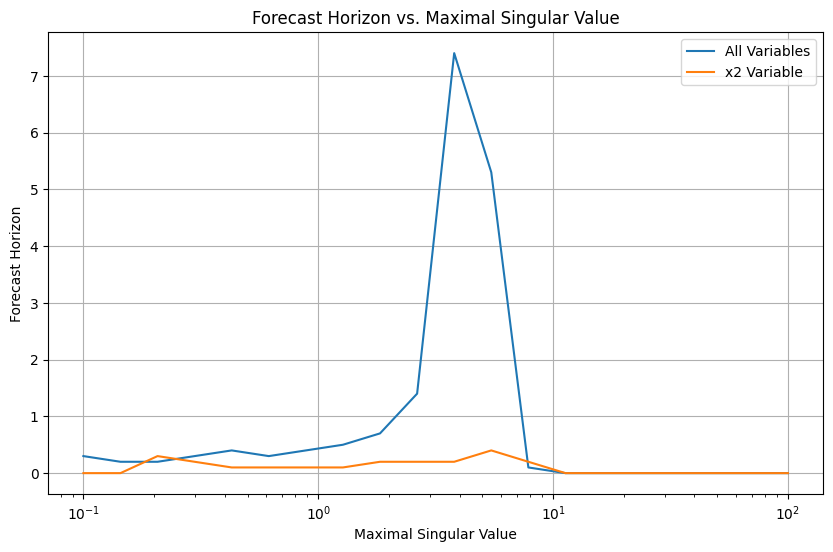

7.847599703514611
shape of t_val: (5001,)
xyz_val shape: (5001, 3)


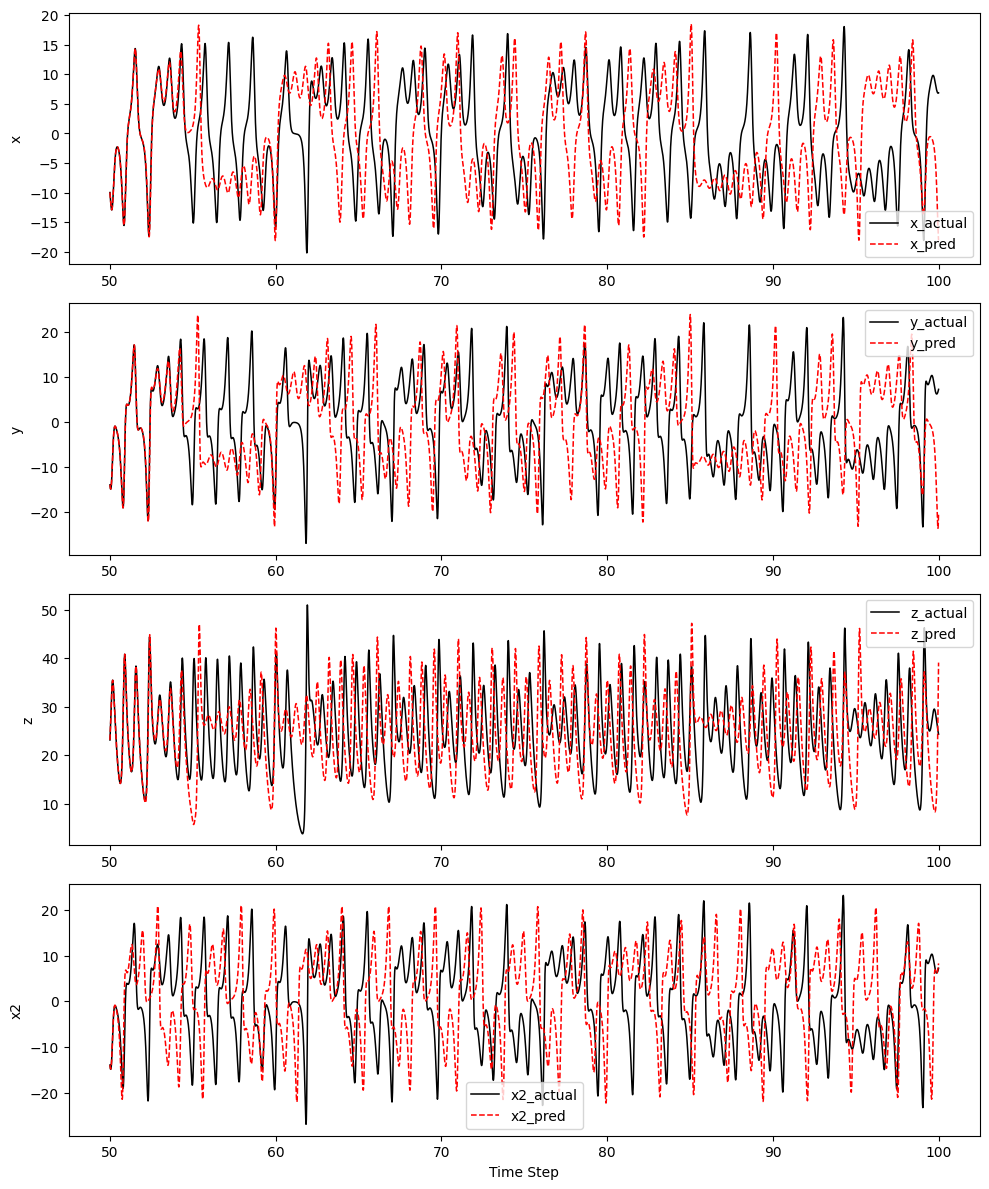

In [72]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Constants
dim_system = 3
dim_reservoir = 500
edge_probability = 0.1
regularization_factor = 0.0001
split_ratio = 0.50
iter_num = 10_000
error_threshold = 0.0001  # Example threshold for forecast horizon

def initialize_weights(dim_reservoir, dim_system, edge_probability):
    """Initialize input weights."""
    return 2 * edge_probability * (np.random.rand(dim_reservoir, dim_system) - 0.5)

def generate_reservoir(dim_reservoir, edge_probability, scaling_factor):
    """Generate the reservoir adjacency matrix."""
    graph = nx.gnp_random_graph(dim_reservoir, edge_probability)
    graph = nx.to_numpy_array(graph)
    A = 2 * (np.random.rand(dim_reservoir, dim_reservoir) - 0.5) * graph
    eigenvalues, _ = np.linalg.eig(A)
    A = A / np.absolute(np.amax(eigenvalues)) * scaling_factor
    return A

def sigmoid(x):
    """Compute the sigmoid function."""
    return np.where(x >= 0, 1 / (1 + np.exp(-x)), np.exp(x) / (1 + np.exp(x)))

def train_reservoir(A, W_in, train_data):
    """Train the reservoir on the training data."""
    dim_reservoir = A.shape[0]
    reservoir_state = np.zeros(dim_reservoir)
    R = np.zeros((dim_reservoir, train_data.shape[0]))

    for i in range(train_data.shape[0]):
        R[:, i] = reservoir_state
        reservoir_state = sigmoid(np.dot(A, reservoir_state) + np.dot(W_in, train_data[i]))

    Rt = np.transpose(R)
    inverse_part = np.linalg.inv(np.dot(R, Rt) + regularization_factor * np.identity(R.shape[0]))
    W_out = np.dot(np.dot(train_data.T, Rt), inverse_part)
    return W_out, reservoir_state

def predict_reservoir(A, W_in, W_out, reservoir_state, steps, dim_system):
    """Make predictions using the trained reservoir."""
    pred = np.zeros((steps, dim_system))

    for i in range(steps):
        pred[i] = np.dot(W_out, reservoir_state)
        reservoir_state = sigmoid(np.dot(A, reservoir_state) + np.dot(W_in, pred[i]))

    return pred

def predict_reservoir_forecast_horizon(A, W_in, W_out, reservoir_state, val_data, error_threshold, dim_system):
    """Predict using the trained reservoir and calculate the forecast horizon."""
    steps = val_data.shape[0]
    pred = np.zeros((steps, dim_system))

    for i in range(steps):
        pred[i] = np.dot(W_out, reservoir_state)
        reservoir_state = sigmoid(np.dot(A, reservoir_state) + np.dot(W_in, pred[i]))

        # Calculate the mean squared error at this step
        mse = np.mean((val_data[i] - pred[i]) ** 2)
        if mse > error_threshold:
            return i/10  # Return the forecast horizon

    return steps  # If error threshold is not exceeded, return the total number of steps

def evaluate_singular_values_forecast_horizon(singular_values, dim_reservoir, edge_probability, train_data, val_data, error_threshold, single_var=False):
    horizons = []
    for scaling_factor in singular_values:
        # Generate reservoir
        A = generate_reservoir(dim_reservoir, edge_probability, scaling_factor)
        W_in = initialize_weights(dim_reservoir, 1 if single_var else dim_system, edge_probability)

        # Train reservoir
        W_out, reservoir_state = train_reservoir(A, W_in, train_data)

        # Predict using reservoir and calculate forecast horizon
        forecast_horizon = predict_reservoir_forecast_horizon(A, W_in, W_out, reservoir_state, val_data, error_threshold, 1 if single_var else dim_system)
        horizons.append(forecast_horizon)

    return horizons

# Main execution
t, x, y, z = lorenz(t0=0, x0=1, y0=1, z0=1, dt=0.01, sigma=10, rho=28, beta=8 / 3, iter_num=iter_num)
print(f'shape of t: {t.shape}')
xyz = np.array(list(zip(x, y, z)))
x2 = y

split_idx = int(iter_num * split_ratio)
t_train, xyz_train = t[:split_idx], xyz[:split_idx]
t_val, xyz_val = t[split_idx:], xyz[split_idx:]
x2_train, x2_val = x2[:split_idx], x2[split_idx:]

singular_values = np.logspace(-1, 2, 20)  # Example range of singular values

# Train and evaluate on the entire Lorenz system
horizons_all_vars = evaluate_singular_values_forecast_horizon(singular_values, dim_reservoir, edge_probability, xyz_train, xyz_val, error_threshold)
print(f'xyz_val shape: {xyz_val.shape}')

# Train and evaluate on only x2 variable
horizons_single_var = evaluate_singular_values_forecast_horizon(singular_values, dim_reservoir, edge_probability, x2_train.reshape(-1, 1), x2_val.reshape(-1, 1), error_threshold, single_var=True)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(singular_values, horizons_all_vars, label="All Variables")
plt.plot(singular_values, horizons_single_var, label="x2 Variable")
plt.xscale('log')
plt.xlabel("Maximal Singular Value")
plt.ylabel("Forecast Horizon")
plt.title("Forecast Horizon vs. Maximal Singular Value")
plt.legend()
plt.grid(True)
plt.show()

# Find the maximum singular value just below 10
max_singular_value = singular_values[np.where(singular_values < 10)[0][-1]]
print(max_singular_value)

# Generate reservoir with this singular value
A = generate_reservoir(dim_reservoir, edge_probability, max_singular_value)
W_in_all = initialize_weights(dim_reservoir, dim_system, edge_probability)
W_in_x2 = initialize_weights(dim_reservoir, 1, edge_probability)

# Train reservoirs
W_out_all, reservoir_state_all = train_reservoir(A, W_in_all, xyz_train)
W_out_x2, reservoir_state_x2 = train_reservoir(A, W_in_x2, x2_train.reshape(-1, 1))

# Predict using reservoirs
pred_all = predict_reservoir(A, W_in_all, W_out_all, reservoir_state_all, len(xyz_val), dim_system)
pred_x2 = predict_reservoir(A, W_in_x2, W_out_x2, reservoir_state_x2, len(x2_val), 1)

# Plot the predictions
fig, axs = plt.subplots(4, 1, figsize=(10, 12))

print(f'shape of t_val: {t_val.shape}')
# Plot for the entire Lorenz system
labels = ['x', 'y', 'z']
for i, label in enumerate(labels):
    axs[i].plot(t_val, xyz_val[:, i], label=f"{label}_actual", color="k", lw=1.1)
    axs[i].plot(t_val, pred_all[:, i], label=f"{label}_pred", color="r", lw=1.1, linestyle='dashed')
    axs[i].set_ylabel(label)
    axs[i].legend()
print(f'xyz_val shape: {xyz_val.shape}')
# Plot for the x2 variable
axs[3].plot(t_val, x2_val, label="x2_actual", color="k", lw=1.1)
axs[3].plot(t_val, pred_x2, label="x2_pred", color="r", lw=1.1, linestyle='dashed')
axs[3].set_ylabel("x2")
axs[3].legend()

axs[3].set_xlabel("Time Step")

fig.tight_layout()
plt.show()